In [22]:
import numpy as np
import scanpy as sc
from numpy.linalg import svd

In [23]:
def compute_svd_rank(embedding_matrix, threshold=0.95):
    """
    Computes the rank of an embedding matrix based on singular values.
    
    Parameters:
        embedding_matrix (numpy.ndarray): The embedding matrix (samples × features)
        threshold (float): The cumulative explained variance threshold (default: 95%)

    Returns:
        effective_rank (int): The number of singular values needed to explain the threshold variance.
        singular_values (numpy.ndarray): The singular values of the embedding matrix.
    """
    U, S, Vt = svd(embedding_matrix, full_matrices=False)
    explained_variance = np.cumsum(S) / np.sum(S)  # Compute cumulative variance explained
    effective_rank = np.searchsorted(explained_variance, threshold) + 1  # Find rank threshold
    return effective_rank, S

In [24]:
adata = sc.read_h5ad("/vevo/umair/data/sens-pred/embs/ccle.h5ad")
adata

AnnData object with n_obs × n_vars = 661 × 16989
    obs: 'ModelID', 'PatientID', 'CellLineName', 'StrippedCellLineName', 'DepmapModelType', 'OncotreeLineage', 'OncotreePrimaryDisease', 'OncotreeSubtype', 'OncotreeCode', 'LegacyMolecularSubtype', 'PatientMolecularSubtype', 'RRID', 'Age', 'AgeCategory', 'Sex', 'PatientRace', 'PrimaryOrMetastasis', 'SampleCollectionSite', 'SourceType', 'SourceDetail', 'TreatmentStatus', 'TreatmentDetails', 'GrowthPattern', 'OnboardedMedia', 'FormulationID', 'TissueOrigin', 'CatalogNumber', 'PlateCoating', 'PublicComments', 'WTSIMasterCellID', 'SangerModelID', 'COSMICID', 'LegacySubSubtype'
    var: 'gene_id', 'feature_name', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'mosaicfm-70m-adapted', 'mosaicfm-70m-from-scratch', 'mosaicfm-70m-merged', 'mosaicfm-70m-pretrained', 'mosaicfm-70m-tahoe', 'mosaicfm-v2-1_3b-merged', 'pca'

In [25]:
models = [
    "pca",
    "mosaicfm-70m-pretrained",
    "mosaicfm-70m-adapted",
    # "mosaicfm-70m-from-scratch",
    # "mosaicfm-70m-tahoe",
    # "mosaicfm-70m-merged",
    # "mosaicfm-v2-1_3b-merged"
]

embedding_matrices = {m: adata.obsm[m] for m in models}

In [26]:
for name, matrix in embedding_matrices.items():
    rank, singular_values = compute_svd_rank(matrix)
    print(f"{name} effective rank: {rank}")

pca effective rank: 14
mosaicfm-70m-pretrained effective rank: 234
mosaicfm-70m-adapted effective rank: 209


In [27]:
import matplotlib.pyplot as plt

In [28]:
def plot_feature_variance(embedding_matrices):
    plt.figure(figsize=(8, 6))

    for name, matrix in embedding_matrices.items():
        if name == "pca":
            continue
        feature_variance = np.var(matrix, axis=0)  # Variance per feature
        plt.plot(sorted(feature_variance, reverse=True), label=name)

    plt.xlabel("Feature Index (sorted by variance)")
    plt.ylabel("Feature Variance")
    plt.title("Feature Variance Distribution Across Embeddings")
    plt.legend()
    plt.show()

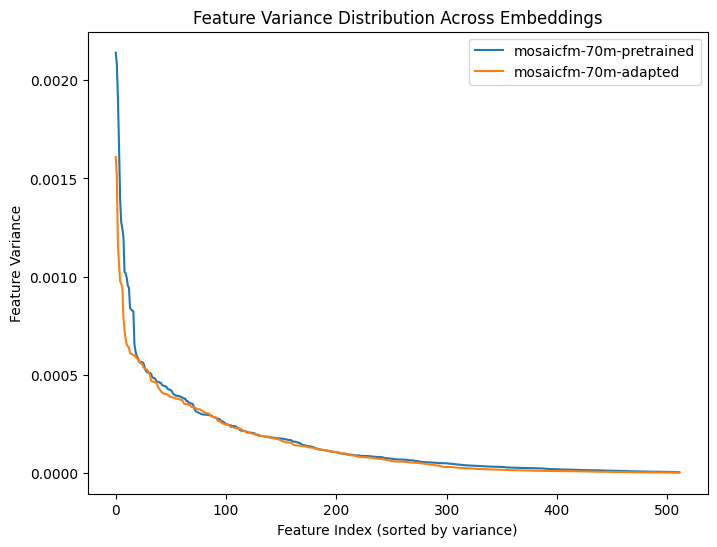

In [29]:
plot_feature_variance(embedding_matrices)

In [30]:
import seaborn as sns

In [31]:
def plot_correlation_heatmap(embedding_matrix, title):
    corr = np.corrcoef(embedding_matrix, rowvar=False)
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(title)
    plt.show()

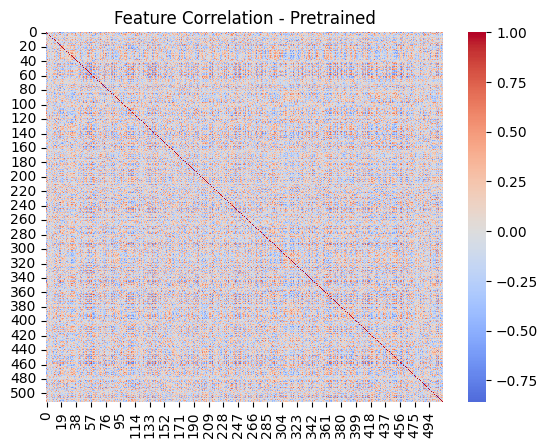

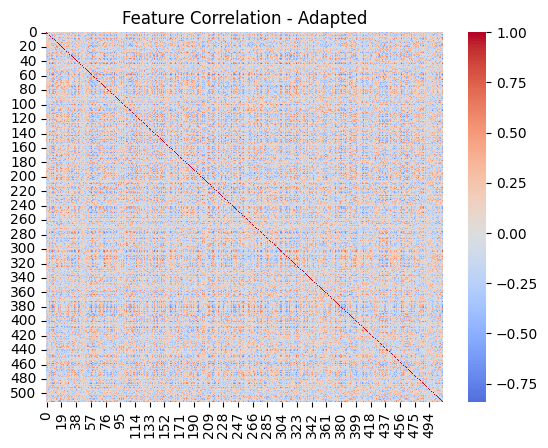

In [32]:
plot_correlation_heatmap(embedding_matrices["mosaicfm-70m-pretrained"], "Feature Correlation - Pretrained")
plot_correlation_heatmap(embedding_matrices["mosaicfm-70m-adapted"], "Feature Correlation - Adapted")

In [33]:
from sklearn.manifold import TSNE

In [34]:
def plot_tsne(embedding_matrix, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embedding_matrix)
    plt.scatter(reduced[:, 0], reduced[:, 1])
    plt.title(title)
    plt.show()

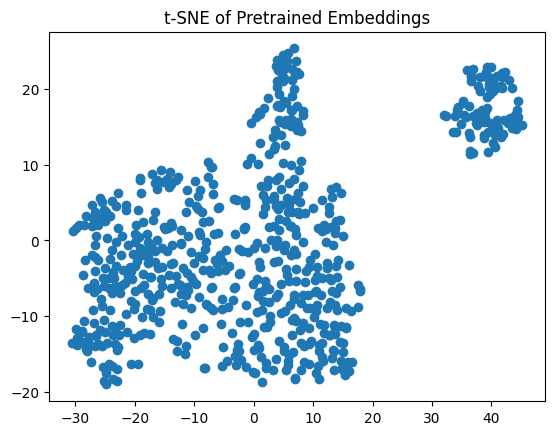

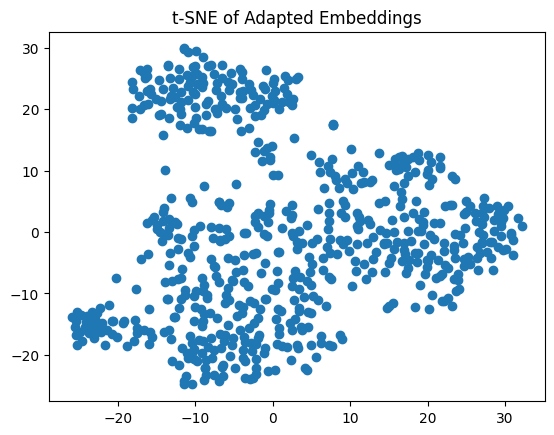

In [35]:
plot_tsne(embedding_matrices["mosaicfm-70m-pretrained"], "t-SNE of Pretrained Embeddings")
plot_tsne(embedding_matrices["mosaicfm-70m-adapted"], "t-SNE of Adapted Embeddings")

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [37]:
def evaluate_clustering(embedding_matrix, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embedding_matrix)
    silhouette = silhouette_score(embedding_matrix, labels)
    return silhouette

In [38]:
print("Pretrained Silhouette Score:", evaluate_clustering(embedding_matrices["mosaicfm-70m-pretrained"]))
print("Adapted Silhouette Score:", evaluate_clustering(embedding_matrices["mosaicfm-70m-adapted"]))

Pretrained Silhouette Score: 0.15768911
Adapted Silhouette Score: 0.12662764


In [ ]:
from scipy.spatial.distance import pdist

In [40]:
def compute_mean_distance(embedding_matrix):
    distances = pdist(embedding_matrix, metric='euclidean')
    return np.mean(distances)

In [41]:
print("Mean distance (Pretrained):", compute_mean_distance(embedding_matrices["mosaicfm-70m-pretrained"]))
print("Mean distance (Adapted):", compute_mean_distance(embedding_matrices["mosaicfm-70m-adapted"]))

Mean distance (Pretrained): 0.39165496621179957
Mean distance (Adapted): 0.370890530365082


### investigate magnitudes

In [64]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
adata_rif = sc.read_h5ad("/vevo/umair/data/sens-pred/embs/rif-dmso-t0-mean.h5ad")
adata_rif

AnnData object with n_obs × n_vars = 52 × 15
    obs: 'cell-line'
    var: 'dim'
    obsm: 'mosaicfm-70m-adapted', 'mosaicfm-70m-from-scratch', 'mosaicfm-70m-merged', 'mosaicfm-70m-pretrained', 'mosaicfm-70m-tahoe', 'mosaicfm-v2-1_3b-merged', 'pca'

In [66]:
adata_ccle = sc.read_h5ad("/vevo/umair/data/sens-pred/embs/ccle.h5ad")
adata_ccle

AnnData object with n_obs × n_vars = 661 × 16989
    obs: 'ModelID', 'PatientID', 'CellLineName', 'StrippedCellLineName', 'DepmapModelType', 'OncotreeLineage', 'OncotreePrimaryDisease', 'OncotreeSubtype', 'OncotreeCode', 'LegacyMolecularSubtype', 'PatientMolecularSubtype', 'RRID', 'Age', 'AgeCategory', 'Sex', 'PatientRace', 'PrimaryOrMetastasis', 'SampleCollectionSite', 'SourceType', 'SourceDetail', 'TreatmentStatus', 'TreatmentDetails', 'GrowthPattern', 'OnboardedMedia', 'FormulationID', 'TissueOrigin', 'CatalogNumber', 'PlateCoating', 'PublicComments', 'WTSIMasterCellID', 'SangerModelID', 'COSMICID', 'LegacySubSubtype'
    var: 'gene_id', 'feature_name', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'mosaicfm-70m-adapted', 'mosaicfm-70m-from-scratch', 'mosaicfm-70m-merged', 'mosaicfm-70m-pretrained', 'mosaicfm-70m-tahoe', 'mosaicfm-v2-1_3b-merged', 'pca'

In [67]:
models = ["mosaicfm-70m-pretrained", "mosaicfm-70m-adapted"]
embs_rif = {m: adata_rif.obsm[m] for m in models}
embs_prism = {m: adata_ccle.obsm[m] for m in models}

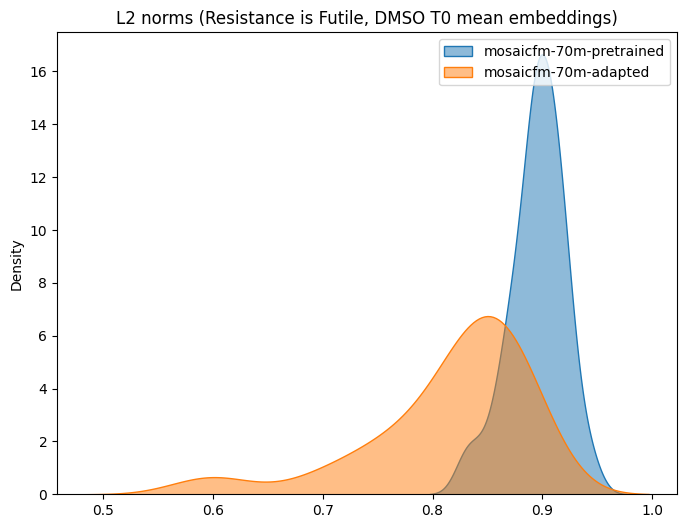

In [68]:
plt.figure(figsize=(8, 6))

for name, matrix in embs_rif.items():
    # norms = np.linalg.norm(matrix, axis=1)
    norms = np.sqrt(np.sum(matrix**2, axis=1))
    sns.kdeplot(norms, label=name, fill=True, alpha=0.5)

plt.title("L2 norms (Resistance is Futile, DMSO T0 mean embeddings)")
plt.legend()
plt.show()

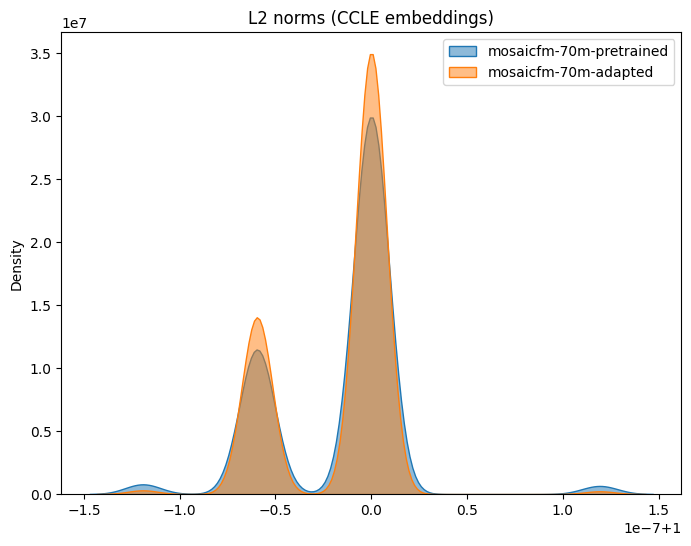

In [69]:
plt.figure(figsize=(8, 6))

for name, matrix in embs_prism.items():
    norms = np.sqrt(np.sum(matrix**2, axis=1))
    sns.kdeplot(norms, label=name, fill=True, alpha=0.5)

plt.title("L2 norms (CCLE embeddings)")
plt.legend()
plt.show()

In [61]:
adata = sc.read_h5ad("/vevo/umair/data/sens-pred/embs/rif-dmso-t0-all.h5ad")
adata

AnnData object with n_obs × n_vars = 30245 × 37392
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'batch', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'mlp_label', 'mlp_confidence', 'cell_line_orig', 'demuxlet_call_orig', 'pass_filter'
    var: 'gene_id', 'genome', 'SUB_LIB_ID-0-0', 'SUB_LIB_ID-1-0', 'SUB_LIB_ID-10-0', 'SUB_LIB_ID-11-0', 'SUB_LIB_ID-12-0', 'SUB_LIB_ID-13-0', 'SUB_LIB_ID-14-0', 'SUB_LIB_ID-15-0', 'SUB_LIB_ID-2-0', 'SUB_LIB_ID-3-0', 'SUB_LIB_ID-4-0', 'SUB_LIB_ID-5-0', 'SUB_LIB_ID-6-0', 'SUB_LIB_ID-7-0', 'SUB_LIB_ID-8-0'

In [62]:
models = ["mosaicfm-70m-pretrained", "mosaicfm-70m-adapted"]
embs = {m: adata.obsm[m] for m in models}

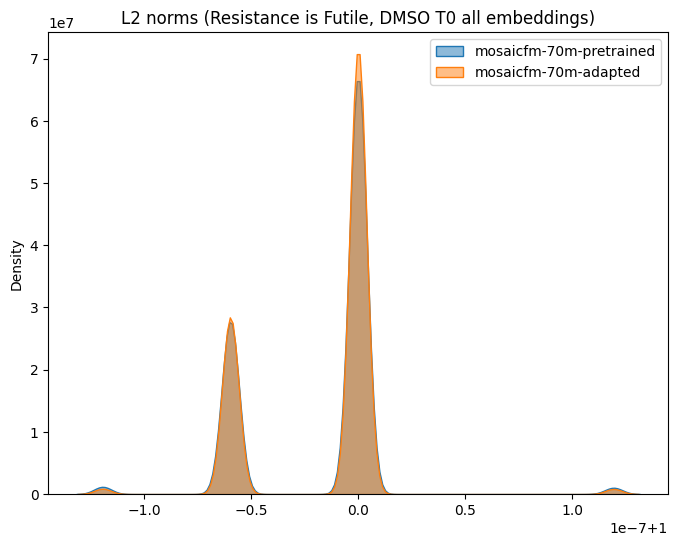

In [63]:
plt.figure(figsize=(8, 6))

for name, matrix in embs.items():
    norms = np.linalg.norm(matrix, axis=1)
    sns.kdeplot(norms, label=name, fill=True, alpha=0.5)

plt.title("L2 norms (Resistance is Futile, DMSO T0 all embeddings)")
plt.legend()
plt.show()

In [9]:
import pandas as pd

In [10]:
df = pd.read_pickle("/vevo/umair/data/sens-pred/mlp-data/dataset.pkl")

In [11]:
df.dtypes

broad_id        object
dosage         float64
cell_line       object
growth_rate    float64
smiles          object
morgan_fp       object
dtype: object

In [13]:
type(df.iloc[0]["morgan_fp"])

numpy.ndarray

In [16]:
df["morgan_fp"].values

array([array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), ...,
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)], dtype=object)

In [4]:
df.isna().sum()

broad_id            0
dosage              0
cell_line           0
growth_rate    364018
smiles              0
morgan_fp           0
dtype: int64

In [5]:
df

,broad_id,dosage,cell_line,growth_rate,smiles,morgan_fp
0,BRD-A00077618-236-07-6,-0.499585,ACH-000007,0.155931,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,BRD-A00077618-236-07-6,-0.499585,ACH-000011,-0.129952,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,BRD-A00077618-236-07-6,-0.499585,ACH-000012,0.264335,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,BRD-A00077618-236-07-6,-0.499585,ACH-000013,0.284202,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,BRD-A00077618-236-07-6,-0.499585,ACH-000015,-0.081515,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
6039911,BRD-U45393375-000-01-6,2.632427,ACH-001192,NaN,NCC=C.ClCC1CO1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6039912,BRD-U45393375-000-01-6,2.632427,ACH-001239,0.187106,NCC=C.ClCC1CO1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6039913,BRD-U45393375-000-01-6,2.632427,ACH-001306,1.033793,NCC=C.ClCC1CO1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6039914,BRD-U45393375-000-01-6,2.632427,ACH-001307,0.429469,NCC=C.ClCC1CO1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/vevo/umair/data/sens-pred/mlp-data/linear-probes.csv")

In [7]:
new_row = {"model": "pca", "split": "random", "r2": 0.34}
new_df = pd.DataFrame([new_row])

In [8]:
pd.concat([df, new_df], ignore_index=True)

/tmp/ipykernel_45258/2314769584.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([df, new_df], ignore_index=True)


,model,split,r2
0,pca,random,0.34


In [3]:
df

,model,split,r2


In [ ]:
to_cat = pd.DataFrame.from_dict({"model": ["pca"], ]"split": "random", "r2": 0.34})

ValueError: If using all scalar values, you must pass an index